In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import random
random.seed(42)
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(42)
import gc
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from glob import glob

# 데이터 로드

In [5]:
path = '.'

In [6]:
train_features = pd.read_csv(path+'/data/train_features.csv')
train_labels = pd.read_csv(path+'/data/train_labels.csv')
test = pd.read_csv(path+'/data/test_features.csv')
sample_submission = pd.read_csv(path + '/data/sample_submission.csv')

In [7]:
train_features.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


In [8]:
train_labels.head()

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise


In [9]:
test.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,3125,0,-0.628100,-0.160155,0.151487,49.665357,88.435961,13.597668
1,3125,1,-0.462548,0.012462,-0.053726,56.953059,96.185341,16.278458
2,3125,2,-0.363481,-0.091789,-0.130004,29.557396,93.836453,13.329043
3,3125,3,-0.351750,-0.239870,-0.193053,23.686172,88.608721,13.449771
4,3125,4,-0.312934,-0.123762,-0.318621,20.410071,85.327707,13.884912


# 데이터 전처리

특별한 전처리 과정 없이 제공된 데이터를 그대로 학습데이터로 활용

In [10]:
x_train = []

for uid in tqdm(train_features['id'].unique()):
    temp = np.array(train_features[train_features['id'] == uid].iloc[:,2:], np.float32).T
    x_train.append(temp)

x_train = np.array(x_train, np.float32)
x_train_ori = x_train[:,:,:,np.newaxis]

x_test = []

for uid in tqdm(test['id'].unique()):
    temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32).T
    x_test.append(temp)

x_test = np.array(x_test, np.float32)
x_test = x_test[:,:,:,np.newaxis]

100%|██████████| 782/782 [00:00<00:00, 1385.49it/s]


In [11]:
x_train[5].shape, x_test[0].shape

((6, 600), (6, 600, 1))

# 데이터 시각화

In [12]:
def vis(uid):
    plt.plot(x_train_ori[uid][0,:,0])
    plt.plot(x_train_ori[uid][1,:,0])
    plt.plot(x_train_ori[uid][2,:,0])
    plt.show()
    
    plt.plot(x_train_ori[uid][3,:,0])
    plt.plot(x_train_ori[uid][4,:,0])
    plt.plot(x_train_ori[uid][5,:,0])
    plt.show()

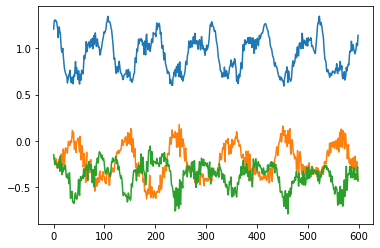

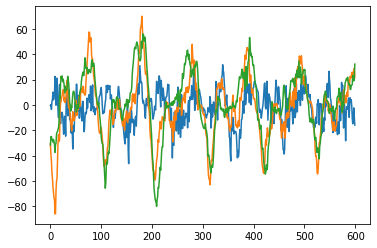

In [13]:
vis(0)

In [14]:
x_train_ori.shape[0]

3125

In [15]:
train_labels['label'].value_counts()

26    1518
8       97
28      55
60      48
18      47
      ... 
53      13
52      12
13      12
12      12
0       12
Name: label, Length: 61, dtype: int64

# 디코더 입력 레이블 추가

In [16]:
train_labels['start'] = 0
target_list = ['start', 'label']
train_labels = train_labels[target_list]

In [17]:
y_train_ori = np.array(train_labels, np.int32)

In [18]:
y_train_ori

array([[ 0, 37],
       [ 0, 26],
       [ 0,  3],
       ...,
       [ 0, 15],
       [ 0, 26],
       [ 0,  2]], dtype=int32)

In [19]:
x_train_ori.shape, y_train_ori.shape

((3125, 6, 600, 1), (3125, 2))

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train_ori, y_train_ori, test_size=0.1, random_state=42)
len(x_train), len(y_train), len(x_val), len(y_val)

(2812, 2812, 313, 313)

# 데이터 증강 및 데이터 로드 함수 정의

In [21]:
def map_func(x_train, y_train):
    x_train = random_shift(x_train)
    return x_train, y_train

def random_shift(data):
    shift = int(random.random()*600)
    data = np.roll(data, shift, axis=1)
    return data

def shift(x, y):
    new = []
    for i in range(5):
        temp = np.roll(x, i*120, axis=1)
        new.extend(temp)
    x = np.array(new)
    y = np.concatenate([y]*5)
    x, y = shuffle(x, y, random_state=42)
    return x,y

In [22]:
shift(x_train, y_train)[0].shape

(14060, 6, 600, 1)

# 하이퍼파라미터

In [23]:
BATCH_SIZE = 64
EPOCHS = 50
early_stopping = 10
num_layers = 1 # 4
dff = 512 # 2048
num_heads = 1 # 8
dropout_rate = 0.2
d_model = 128 # 512
target_size = 61
base_channel = 16
k = 10
learning_rate = 0.00005

# 데이터셋 구성

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(x_val.shape[0])
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [25]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([64, 6, 600, 1]), TensorShape([64, 2]))

In [26]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([313, 6, 600, 1]), TensorShape([313, 2]))

# 모델 정의

트랜스포머에서 불필요한 레이어 삭제 및 레이어 추가

In [27]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [28]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [29]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [30]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [31]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [33]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
                                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                                tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
                                ])

## 인코더

6x600의 입력데이터를 1x2 커널을 활용해 다른 데이터끼리 간섭 없이 convolution 및 pooling 진행

In [34]:
class EncoderLayer(tf.keras.Model):
    def __init__(self, d_model, num_heads, dff, rate):
        super(EncoderLayer, self).__init__()
        
        self.fc = tf.keras.layers.Dense(d_model, activation='relu')
        
        self.pos_encoding = positional_encoding(500, d_model)       
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x):        
        seq_len = tf.shape(x)[1]
        x += self.pos_encoding[:, :seq_len, :]
        
        attn, attn_weights_block = self.mha1(x, x, x, None)  # (batch_size, target_seq_len, d_model)
        attn = self.dropout1(attn)
        out = self.layernorm1(attn + x)
        
        ffn_output = self.ffn(out)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out = self.layernorm2(ffn_output + out)
        
        return out

In [35]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate):
        super(Encoder, self).__init__()
        
        self.num_layers = num_layers
        self.feature_extract_model = self.cnn_base(base_channel)
        self.fc = tf.keras.layers.Dense(d_model, activation='relu')
        #self.pos_encoding = positional_encoding(114, d_model)
        self.dropout = tf.keras.layers.Dropout(rate)
        
        #self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)]

    def call(self, x, training):
        x = self.feature_extract_model(x)
        x = tf.keras.layers.Reshape((-1, x.shape[3]))(x)
        x = self.fc(x)
        seq_len = tf.shape(x)[1]
        #print(seq_len)
        #x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        #for i in range(self.num_layers):
        #    x = self.enc_layers[i](x)
        
        x = tf.keras.layers.Reshape((1, -1))(x)
        
        return x  # (batch_size, input_seq_len, d_model)
    
    def cnn_base(self, base_channel=8):
        input_layer = tf.keras.layers.Input(shape=(6, 600, 1))
        
        x = tf.keras.layers.Conv2D(base_channel*2, (1, 2), activation='relu', padding='same')(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)
        
        x = tf.keras.layers.Conv2D(base_channel*4, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        x = tf.keras.layers.Conv2D(base_channel*8, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        x = tf.keras.layers.Conv2D(base_channel*16, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        x = tf.keras.layers.Conv2D(base_channel*32, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        output_layer = tf.keras.layers.Conv2D(base_channel*64, (1, 2), activation='relu', padding='same')(x)
        
        return tf.keras.models.Model(input_layer, output_layer)

In [36]:
sample_encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, rate=dropout_rate)
temp_input = next(iter(train_dataset))[0]

sample_encoder_output = sample_encoder(temp_input, False)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 1, 14592)


## 디코더

In [37]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3#, attn_weights_block1, attn_weights_block2

In [38]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            #attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            #attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x#, attention_weights

In [39]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_size=target_size,
                         maximum_position_encoding=500)
temp_input = next(iter(train_dataset))[1]#tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output = sample_decoder(temp_input, 
                        enc_output=sample_encoder_output, 
                        training=False,
                        look_ahead_mask=None, 
                        padding_mask=None)

output.shape#, attn['decoder_layer2_block2'].shape

TensorShape([64, 2, 512])

## 트랜스포머

In [40]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, target_size, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, dropout_rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_size, activation='softmax')

    def call(self, inp, tar, training, look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_size)
        
        return final_output#, attention_weights

## 옵티마이저 및 loss 함수 정의

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [42]:
def loss_object(y, y_hat):
    y = tf.one_hot(tf.cast(y, tf.int32), target_size)
    return tf.keras.losses.categorical_crossentropy(y, y_hat, from_logits=False, label_smoothing = 0.0)

In [44]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, -1))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    real = tf.dtypes.cast(real, tf.int64)
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, -1))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [45]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          target_size, 
                          pe_target=target_size,
                          rate=dropout_rate)

In [46]:
def create_masks(tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask

In [47]:
inp = next(iter(train_dataset))[0]
tar_inp = next(iter(train_dataset))[1][:,:-1]
combined_mask = create_masks(tar_inp)
transformer(inp, tar_inp, True, combined_mask, dec_padding_mask=None).shape

TensorShape([64, 1, 61])

## 체크포인트 설정

초기화 된 체크포인트를 저장

In [48]:
!rm -r ./checkpoints

In [49]:
init_path = path+"/checkpoints/init"

init_ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

init_ckpt_manager = tf.train.CheckpointManager(init_ckpt, init_path, max_to_keep=5)

init_ckpt_manager.save()

'./checkpoints/init/ckpt-1'

## 학습 함수 정의

In [50]:
@tf.function()
def train_step(inp, tar, training=True):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    with tf.GradientTape() as tape:
        predictions = transformer(inp, tar_inp,
                                  True,
                                  None,
                                  None)
        loss = loss_function(tar_real, predictions)
    if training==True:
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        train_accuracy(accuracy_function(tar_real, predictions))
    else:
        val_accuracy(accuracy_function(tar_real, predictions))
  
    return loss, predictions

## 평가 함수 정의

In [ ]:
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')
gc.collect()

# 학습

10fold 교차검증

각 fold 학습 전 초기화 checkpoint 복원

0it [00:00, ?it/s]

Init checkpoint restored!!


196it [00:09, 21.55it/s, Epoch=1, k=0, Loss=2.115212, Total Loss=2.246676, Accuracy=0.538]
10it [00:00, 10.16it/s, Epoch=1, k=0, Val Loss=1.726462, Val Total_Loss=1.751871, Val Accuracy=0.594]
196it [00:06, 31.75it/s, Epoch=2, k=0, Loss=1.426604, Total Loss=1.430660, Accuracy=0.658]
10it [00:00, 36.17it/s, Epoch=2, k=0, Val Loss=1.439654, Val Total_Loss=1.376486, Val Accuracy=0.677]
196it [00:06, 31.24it/s, Epoch=3, k=0, Loss=1.432707, Total Loss=1.139765, Accuracy=0.718]
10it [00:00, 34.44it/s, Epoch=3, k=0, Val Loss=1.390454, Val Total_Loss=1.206229, Val Accuracy=0.701]
196it [00:06, 31.83it/s, Epoch=4, k=0, Loss=1.078606, Total Loss=0.964550, Accuracy=0.754]
10it [00:00, 35.55it/s, Epoch=4, k=0, Val Loss=1.206398, Val Total_Loss=1.050820, Val Accuracy=0.726]
196it [00:06, 31.05it/s, Epoch=5, k=0, Loss=0.936368, Total Loss=0.823648, Accuracy=0.791]
10it [00:00, 34.69it/s, Epoch=5, k=0, Val Loss=1.157393, Val Total_Loss=0.962742, Val Accuracy=0.759]
196it [00:06, 31.85it/s, Epoch=6, k

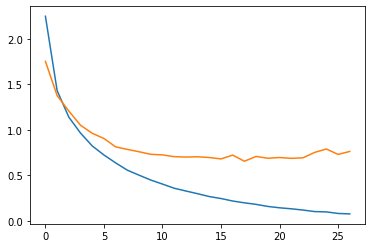

0it [00:00, ?it/s, Epoch=1, k=1, Loss=4.637722, Total Loss=4.637722, Accuracy=0.0312]

Init checkpoint restored!!


196it [00:06, 31.92it/s, Epoch=1, k=1, Loss=0.644441, Total Loss=2.299504, Accuracy=0.535]
10it [00:00, 35.70it/s, Epoch=1, k=1, Val Loss=1.837503, Val Total_Loss=1.702720, Val Accuracy=0.609]
196it [00:06, 30.74it/s, Epoch=2, k=1, Loss=0.533386, Total Loss=1.430574, Accuracy=0.66] 
10it [00:00, 34.42it/s, Epoch=2, k=1, Val Loss=1.453387, Val Total_Loss=1.311229, Val Accuracy=0.656]
196it [00:06, 31.12it/s, Epoch=3, k=1, Loss=0.498778, Total Loss=1.140933, Accuracy=0.713]
10it [00:00, 35.21it/s, Epoch=3, k=1, Val Loss=1.124260, Val Total_Loss=1.121335, Val Accuracy=0.712]
196it [00:06, 31.07it/s, Epoch=4, k=1, Loss=0.278927, Total Loss=0.965387, Accuracy=0.755]
10it [00:00, 35.52it/s, Epoch=4, k=1, Val Loss=1.072010, Val Total_Loss=1.041883, Val Accuracy=0.738]
196it [00:06, 31.71it/s, Epoch=5, k=1, Loss=0.325582, Total Loss=0.828787, Accuracy=0.786]
10it [00:00, 35.07it/s, Epoch=5, k=1, Val Loss=0.925019, Val Total_Loss=0.920871, Val Accuracy=0.75]
196it [00:06, 31.45it/s, Epoch=6, k=

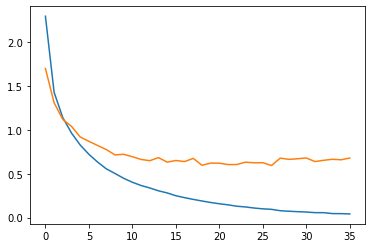

0it [00:00, ?it/s, Epoch=1, k=2, Loss=4.671291, Total Loss=4.671291, Accuracy=0]

Init checkpoint restored!!


196it [00:06, 31.13it/s, Epoch=1, k=2, Loss=1.057811, Total Loss=2.246069, Accuracy=0.538]
10it [00:00, 36.64it/s, Epoch=1, k=2, Val Loss=1.314685, Val Total_Loss=1.717830, Val Accuracy=0.597]
196it [00:06, 31.46it/s, Epoch=2, k=2, Loss=0.804435, Total Loss=1.414047, Accuracy=0.661]
10it [00:00, 35.66it/s, Epoch=2, k=2, Val Loss=0.904909, Val Total_Loss=1.370210, Val Accuracy=0.681]
196it [00:06, 31.10it/s, Epoch=3, k=2, Loss=0.757489, Total Loss=1.140079, Accuracy=0.716]
10it [00:00, 34.71it/s, Epoch=3, k=2, Val Loss=0.863774, Val Total_Loss=1.139674, Val Accuracy=0.707]
196it [00:06, 31.60it/s, Epoch=4, k=2, Loss=0.533627, Total Loss=0.970599, Accuracy=0.755]
10it [00:00, 34.16it/s, Epoch=4, k=2, Val Loss=0.666122, Val Total_Loss=1.020821, Val Accuracy=0.733]
196it [00:06, 31.22it/s, Epoch=5, k=2, Loss=0.557961, Total Loss=0.839559, Accuracy=0.783]
10it [00:00, 33.98it/s, Epoch=5, k=2, Val Loss=0.598747, Val Total_Loss=0.902081, Val Accuracy=0.761]
196it [00:06, 30.86it/s, Epoch=6, k

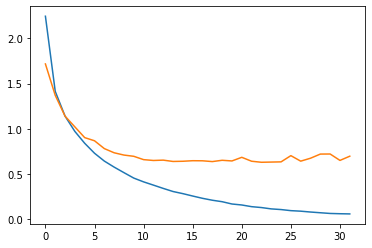

0it [00:00, ?it/s, Epoch=1, k=3, Loss=4.819783, Total Loss=4.819783, Accuracy=0.0156]

Init checkpoint restored!!


196it [00:06, 31.02it/s, Epoch=1, k=3, Loss=1.948639, Total Loss=2.241064, Accuracy=0.537]
10it [00:00, 35.65it/s, Epoch=1, k=3, Val Loss=1.615447, Val Total_Loss=1.660377, Val Accuracy=0.609]
196it [00:06, 31.32it/s, Epoch=2, k=3, Loss=1.397542, Total Loss=1.410805, Accuracy=0.659]
10it [00:00, 34.50it/s, Epoch=2, k=3, Val Loss=1.173093, Val Total_Loss=1.352516, Val Accuracy=0.665]
196it [00:06, 31.36it/s, Epoch=3, k=3, Loss=1.054423, Total Loss=1.130174, Accuracy=0.717]
10it [00:00, 34.40it/s, Epoch=3, k=3, Val Loss=0.922910, Val Total_Loss=1.173321, Val Accuracy=0.718]
196it [00:06, 31.30it/s, Epoch=4, k=3, Loss=0.977842, Total Loss=0.948809, Accuracy=0.757]
10it [00:00, 34.97it/s, Epoch=4, k=3, Val Loss=0.899780, Val Total_Loss=1.051738, Val Accuracy=0.732]
196it [00:06, 31.18it/s, Epoch=5, k=3, Loss=0.685495, Total Loss=0.807250, Accuracy=0.791]
10it [00:00, 35.56it/s, Epoch=5, k=3, Val Loss=0.794605, Val Total_Loss=0.964069, Val Accuracy=0.747]
196it [00:06, 31.57it/s, Epoch=6, k

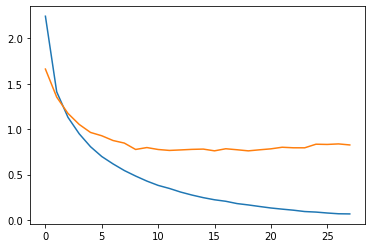

0it [00:00, ?it/s, Epoch=1, k=4, Loss=4.670118, Total Loss=4.670118, Accuracy=0.0156]

Init checkpoint restored!!


196it [00:06, 30.88it/s, Epoch=1, k=4, Loss=2.020737, Total Loss=2.274522, Accuracy=0.535]
10it [00:00, 35.02it/s, Epoch=1, k=4, Val Loss=2.220313, Val Total_Loss=1.705879, Val Accuracy=0.615]
196it [00:06, 30.88it/s, Epoch=2, k=4, Loss=1.399983, Total Loss=1.426917, Accuracy=0.653]
10it [00:00, 35.13it/s, Epoch=2, k=4, Val Loss=1.692500, Val Total_Loss=1.347027, Val Accuracy=0.66]
196it [00:06, 31.21it/s, Epoch=3, k=4, Loss=1.124068, Total Loss=1.140195, Accuracy=0.713]
10it [00:00, 35.20it/s, Epoch=3, k=4, Val Loss=1.580915, Val Total_Loss=1.186990, Val Accuracy=0.695]
196it [00:06, 31.93it/s, Epoch=4, k=4, Loss=0.955350, Total Loss=0.967626, Accuracy=0.753]
10it [00:00, 35.77it/s, Epoch=4, k=4, Val Loss=1.355157, Val Total_Loss=1.076557, Val Accuracy=0.723]
196it [00:06, 31.12it/s, Epoch=5, k=4, Loss=0.889303, Total Loss=0.833045, Accuracy=0.785]
10it [00:00, 35.05it/s, Epoch=5, k=4, Val Loss=1.294078, Val Total_Loss=1.022948, Val Accuracy=0.761]
196it [00:06, 31.49it/s, Epoch=6, k=

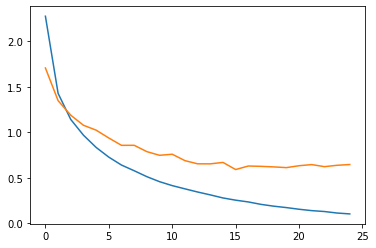

In [52]:
k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(k_fold.split(x_train_ori, y_train_ori[:,1])):
    x_train, y_train = x_train_ori[train_idx], y_train_ori[train_idx]
    x_val, y_val = x_train_ori[val_idx], y_train_ori[val_idx]    
    
    x_train, y_train = shift(x_train, y_train)
    #x_val, y_val = shift(x_val, y_val)
    x_train, y_train = shuffle(x_train, y_train)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    if init_ckpt_manager.latest_checkpoint:
        init_ckpt.restore(init_ckpt_manager.latest_checkpoint)
        print ('Init checkpoint restored!!')
    
    checkpoint_path = path+f"/checkpoints/model_{i}"

    ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
    loss_plot, val_loss_plot = [], []
    for epoch in range(EPOCHS):
        total_loss, total_val_loss = 0, 0
        train_accuracy.reset_states()
            
        tqdm_dataset = tqdm(enumerate(train_dataset))
        
        for (batch, (tensor, target)) in tqdm_dataset:
            
            batch_loss, pred_list = train_step(tensor, target, training=True)
            total_loss += batch_loss
            
            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'k': i,
                'Loss': '{:06f}'.format(batch_loss.numpy()),
                'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
                'Accuracy':train_accuracy.result().numpy(), 
            })
            if batch % 30 == 0:
                gc.collect()

        loss_plot.append(total_loss / (batch+1))
        
        val_accuracy.reset_states()
        
        tqdm_dataset_val = tqdm(enumerate(val_dataset))

        for (batch, (tensor, target)) in tqdm_dataset_val:

            batch_val_loss, pred_list = train_step(tensor, target, training=False)
            total_val_loss += batch_val_loss
            
            tqdm_dataset_val.set_postfix({
                'Epoch': epoch + 1,
                'k': i,
                'Val Loss': '{:06f}'.format(batch_val_loss.numpy()),
                'Val Total_Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
                'Val Accuracy':val_accuracy.result().numpy(), 
            })
            
        val_loss_plot.append(total_val_loss / (batch+1))
        
        if np.min(val_loss_plot) == val_loss_plot[-1]:
            ckpt_manager.save()
        
        if epoch >= early_stopping and np.min(val_loss_plot[-early_stopping:]) == val_loss_plot[-early_stopping]:
            break
    
    plt.plot(loss_plot)
    plt.plot(val_loss_plot)
    plt.show()

In [53]:
gc.collect()

2733

# 추론 함수 정의

In [54]:
@tf.function
def evaluate(tensor):
    decoder_input = [0] * tensor.shape[0]
    output = tf.expand_dims(decoder_input,1)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions = transformer(tensor,
                              output,
                              False,
                              None,
                              None)
    
    # select the last word from the seq_len dimension
    proba = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
    
    predicted_id = tf.cast(tf.argmax(proba, axis=-1), tf.int32)
    
    output = tf.concat([output, predicted_id], axis=-1)

    return output, proba

## TTA 함수 정의

In [55]:
def test_map_func(data):
    data = np.roll(data, j*10, axis=1)
    return data

In [56]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test))
test_dataset = test_dataset.map(lambda item1: tf.numpy_function(test_map_func, [item1], [tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 추론

In [57]:
preds = []

for i in range(k):
    checkpoint_path = path+f"/checkpoints/model_{i}"
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
    
    for j in tqdm(range(60)):
        pred = []
        for batch in iter(test_dataset):
            output, proba = evaluate(batch[0])
            proba = proba.numpy()[:,0,:]
            pred.extend(proba)
        pred = np.array(pred)
        preds.append(pred)

100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


# 앙상블 및 제출

In [58]:
pred = np.mean(preds, axis=0)

In [59]:
sample_submission.iloc[:,1:] = pred

In [60]:
sample_submission

,id,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,3125,0.000831,6.605953e-04,1.274750e-04,6.436799e-04,1.047896e-03,0.000033,2.589992e-03,6.602274e-03,0.000008,...,1.249994e-02,1.452982e-03,3.048334e-03,9.570552e-04,5.962851e-05,2.295175e-04,0.000252,7.524589e-02,1.208344e-04,0.000153
1,3126,0.000591,1.400989e-04,3.191709e-06,7.375595e-05,4.392918e-05,0.000129,2.204269e-05,2.765137e-04,0.000012,...,4.150725e-06,1.756887e-05,2.753128e-05,6.739267e-05,8.481072e-05,8.093557e-05,0.002746,7.568773e-05,8.220512e-05,0.000177
2,3127,0.002012,3.520753e-02,2.919007e-05,5.320263e-04,3.032702e-05,0.000599,1.420229e-04,6.110428e-04,0.002983,...,1.762791e-05,1.412787e-04,1.429662e-04,1.532332e-02,8.171324e-05,2.187825e-04,0.000056,4.201277e-05,2.538917e-03,0.001018
3,3128,0.000054,3.287630e-06,1.864961e-05,3.236853e-06,8.615674e-07,0.000003,8.541592e-06,2.141009e-06,0.000008,...,4.766217e-06,1.443075e-05,6.212510e-06,1.627816e-05,1.245904e-05,2.186957e-06,0.000034,4.607265e-06,1.398872e-06,0.000044
4,3129,0.000056,1.526584e-06,2.705126e-07,1.728681e-06,8.093693e-06,0.000004,1.958829e-06,9.415847e-07,0.000003,...,1.370269e-06,3.072895e-06,7.545499e-07,8.253959e-07,4.713930e-07,1.093943e-06,0.000007,7.471754e-07,4.557480e-07,0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.000300,6.029083e-06,8.796888e-07,2.521420e-07,1.360858e-04,0.000012,2.016608e-06,8.516466e-06,0.000011,...,3.176310e-06,1.022096e-05,4.121788e-06,2.679337e-06,1.075466e-06,7.658955e-07,0.000166,2.201070e-06,1.417405e-06,0.000139
778,3903,0.000032,2.670637e-06,4.121725e-07,5.528962e-06,1.596971e-06,0.000018,2.766173e-06,4.635297e-07,0.000003,...,2.260644e-06,2.791079e-06,2.899571e-06,6.088819e-06,2.146376e-06,1.143142e-05,0.000014,1.030003e-06,5.941918e-07,0.000029
779,3904,0.000020,1.717583e-06,5.692573e-07,2.064381e-06,1.592880e-06,0.000002,1.236207e-06,2.610548e-07,0.000003,...,5.543832e-07,1.246475e-06,7.107570e-07,8.104086e-07,9.033349e-07,1.467922e-06,0.000010,1.250802e-06,8.996398e-07,0.000011
780,3905,0.000045,5.692340e-04,4.960470e-06,3.777838e-06,2.789270e-05,0.000004,6.244658e-04,9.112439e-05,0.000006,...,3.075799e-06,2.296756e-05,2.971411e-06,6.535201e-05,2.298386e-06,3.003649e-05,0.000135,5.485306e-05,4.503372e-05,0.000003


In [61]:
sample_submission.to_csv(path+'/submission.csv', index=False)
sample_submission.to_csv('./submission.csv', index=False)